## pytorch下的tensorboard可视分析

In [6]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
# 转换向量 规范化
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))]
)

In [8]:
# datasets
trainset = torchvision.datasets.FashionMNIST('./data1',
    download=True,
    train=True,
    transform=transform)

testset = torchvision.datasets.FashionMNIST('./data1',
    download=True,
    train=False,
    transform=transform)

26422272it [00:07, 3377487.79it/s]                              


Extracting ./data1/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data1/FashionMNIST/raw



29696it [00:00, 71916.04it/s]                           


Extracting ./data1/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data1/FashionMNIST/raw



4422656it [00:03, 1415906.93it/s]                             


Extracting ./data1/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data1/FashionMNIST/raw



6144it [00:00, 10428896.71it/s]         

Extracting ./data1/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data1/FashionMNIST/raw




/Users/zhongshannan/opt/anaconda3/envs/Py38/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
# dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

In [10]:
# class
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [11]:
# 显图函数
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 卷积-激活-池化
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4) # 重调大小
        x = F.relu(self.fc1(x)) #全连接-激活
        x = F.relu(self.fc2(x))
        x = self.fc3(x) #全连接
        return x

net = Net()

In [13]:
# 损失函数 优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 启用tensorboard

In [14]:
from torch.utils.tensorboard import SummaryWriter
# 定义一个SummaryWriter关键对象writer，用于写入信息 会单独创建一个新的文件夹
writer = SummaryWriter('runs/fanshion_mnist_experiment_1')

## 写入tensorboard

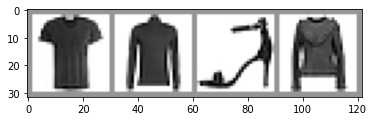

In [15]:
# 将图像写入tensorboard的网格
dataiter = iter(trainloader) # 随机获取图像的迭代器
images, label =  dataiter.next() # 返回迭代器的下一个项目

# 创建图像网格
img_grid = torchvision.utils.make_grid(images)

#显图
matplotlib_imshow(img_grid, one_channel=True)

#写入tensorboard 4个网格
writer.add_image('four_fashion_mnist_images', img_grid)

## 利用tensorboard查看模型

In [16]:
# 可视化构建的复杂模型
writer.add_graph(net, images)
writer.close()

/Users/zhongshannan/opt/anaconda3/envs/Py38/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## 加入Projector至tensorboard

In [17]:
# 利用add_embedding方法可视化高维数据的低维表示

def select_n_random(data, labels, n=100):
    # 从数据集中选择n个随机数据点及其对应的标签
    assert len(data) == len(labels)
    perm = torch.randperm(len(data)) # 生成data长度的连续整数数组的随机排列
    return data[perm][:n], labels[perm][:n] # 返回

# 随机选择图像及其标签
images, labels = select_n_random(trainset.data, trainset.targets)

# 获取每张图像的类标签
class_labels = [classes[i] for i in labels]

# 记录embedding
features = images.view(-1, 28*28) # view(-1,)会进行自动匹配大小
writer.add_embedding(features,
                    metadata  = class_labels,
                    label_img = images.unsqueeze(1))
writer.close()

## 利用tensorboard追踪训练模型

In [18]:
# 将训练损失记录到tensorboard，并通过plot_classes_preds函数查看模型所做的预测

def images_to_probs(net, images):
    # 从训练后的网络和图像中生成预测和对应概率
    output = net(images)
    # 将输出概率转换为预测类别
    _, preds_tensor = torch.max(output, 1)  # _,的作用尚不明
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]  # zip打包成对应元组的列表

def plot_classes_preds(net, images, labels):
    # 使用训练后的网络以及批处理的图像和标签生产matploylib图像
    # 显示网络最后一层的预测、概率以及实际的标签
    # 并根据预测是否正确对该信息着色
    preds, probs = images_to_probs(net, images)
    # 绘制batch中的图像，以及预测和真实标签
    fig = plt.figure(figsize = (12,48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

## 利用add_scalar函数将1000个batch写入tensorboard
## 在scalar标签下可以查看15000次迭代训练的运行损失

In [19]:
# 此外，在训练时，将生产一张图像，显示模型的预测与该batch中包含的四张图像的实际结果。

running_loss = 0.0
for epoch in range(1):  # 多次循环数据集（作用？）
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data  # 获取训练集输入，形式列表[inputs,labels]
        optimizer.zero_grad()  # 梯度归零
        outputs = net(inputs)  # forward
        loss = criterion(outputs, labels)  # 计算loss
        loss.backward()  # backward
        optimizer.step()  # optimize

        running_loss += loss.item()  # 累积loss
        if i % 1000 == 999:  # 每1000个mini-batches
            # 记录训练损失
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)
            # 记录图像对比 随机mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training
